In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import pickle
import itertools

from pathlib import Path as PPath
from multiprocessing import Pool

from genetic.data_definitions import CartesianPoint, Mapa
from genetic.visualization import plot_map, vis_mapa

from genetic.genetic import Genetic, Subject


# def read_tipos(labels):
#     # tipos = []
#     # for i, y in zip(range(50), labels):
#     map_tipos = []
#     for j in range(20):
#         if j in labels:
#             map_tipos.append('b')
#         else:
#             map_tipos.append('n')
#     return map_tipos
#         # tipos.append(map_tipos)
#     # return tipos


def read_bonus(path):
    with open(path, 'r') as f:
        labels = []
        for i in f:
            map_labels = []
            for j in re.sub('\n', '', i).split(','):
                map_labels.append(int(j))
            labels.append(map_labels)
    return labels


def separate_areas(areas, indexes):
    areas_n = []
    areas_b = []

    for i, area in enumerate(areas):
        if i in indexes:
            areas_b.append(area)
        else:
            areas_n.append(area)

    return areas_n, areas_b


def sgl_read_areas(lines):
    """From the map file definition reads each area"""

    lines = iter(lines)
    next(lines)  # <number of polygons>
    next(lines)  # 20

    areas = []

    for line in lines:
        Xs = [float(n) for n in re.sub(r"\n", "", next(lines)).split(",")]
        Ys = [float(n) for n in re.sub(r"\n", "", next(lines)).split(",")]

        areas.append([CartesianPoint(x, y) for x, y in zip(Xs, Ys)])

    return areas


def read_sgl(path, **kwargs):
    with open(path, "r") as f:
        lines = f.readlines()
        areas = sgl_read_areas(lines)

        if 'bonus_index' in kwargs:
            areas_n, areas_b = separate_areas(areas, kwargs['bonus_index'])
        else:
            areas_n = areas
            areas_b = []

        # inflation_rate=1, mode='scalar'
        map = Mapa(wp_ori, wp_des, areas_n, areas_b,
                   inflation_rate=kwargs['inflation_rate'])
    return map


def run_ags_over_path(path, show=False):
    path = str(path)
    number = re.sub(r"[A-Za-z/\-_\.]", "", path)
    print(f"1. Processing file: {number}")
    # map = read_sgl(path, inflation_rate=0.1)  # , mode="vector")
    map = read_sgl(path, inflation_rate=0.1, bonus_index=labels[int(number)])
    # tipos = read_tipos(bonus_labels[int(number)])

    print("1.1. Read")

    ag = Genetic(
        Subject,
        map,
        # version=Version("beta", "RC"),
        # Parâmetros da classe Subject:
        px0=map.origin.x,
        py0=map.origin.y,
        **par_RC,
    )

    best = ag.run(info=False)
    print(f"2. AG generated: {number}")
    name = EXPERIMENTS_PATH + f"mode_{MODE}_map_{str(number)}_exec_{EXEC}"

    history = ag.history
    df = pd.DataFrame(history)
    df.to_csv(name + "_history.csv", index=False)

    vis_mapa(map, best.get_route(), save=name + "_best.png")

    with open(name + "_ag.p", "wb") as ag_file:
        pickle.dump(ag, ag_file)

    # res = np.array([[subject.fitness, subject.birth_time] for subject in ag.ancestry])
    # plot_fitness(
    #     res,
    #     map,
    #     ag,
    #     name + "_fitness.png",
    #     name + "_fitness2.png",
    #     name + "_stats.csv",
    #     name + "_bestall.png",
    #     show,
    # )

    print(f"2. Saved: {number}")

    return ag


def get_specific(array, birth_time_target):
    # returns index of element with closest birth time as the one provided in an array
    birth_time_specific = array[:, 1].flat[
        np.abs(array[:, 1] - birth_time_target).argmin()
    ]
    return np.where(np.isclose(array, birth_time_specific))[0][0]


def plot_fitness(
    np_ar, mapa, ag, name_fig, name_fig2, name_table, name_routes, show=False
):
    colors = sub_colors = pl.cm.jet(np.linspace(0, 1, 7))

    plt.figure(figsize=(15, 10))
    plt.plot(np_ar[:, 1], np_ar[:, 0], color=colors[0])
    if show:
        plt.show()

    sub_routes = []
    sub_names = []
    table = []
    for a, j in enumerate(range(0, 190, 10)):
        index = get_specific(np_ar, j)
        point = np_ar[index]
        plt.vlines(
            point[1],
            0,
            point[0],
            color=sub_colors[a],
            linestyle="dashed",
            linewidth=1,
            alpha=0.8,
            label=str(j),
        )
        plt.hlines(
            point[0],
            0,
            point[1],
            color=sub_colors[a],
            linestyle="dashed",
            linewidth=1,
            alpha=0.8,
        )
        table.append(
            np.append(
                index,
                np.append([str(ag.ancestry[index].fitness_trace)],
                          np.append(point, j)),
            )
        )
        plt.legend()
        sub_routes.append(ag.ancestry[index].get_route())
        sub_names.append(str(j))

    plt.savefig(name_fig)
    if show:
        plt.show()

    table = pd.DataFrame(table)
    table.columns = [
        "Individual #",
        "Fitness Trace [d, obs, con, cur, t]",
        "Fitness",
        "Real Birth Time",
        "Margin Birth Time",
    ]
    aux_table = table.iloc[:, ::-1].round(2)
    aux_table.to_csv(name_table, index=False)

    plt.figure()
    plt.plot(table["Margin Birth Time"], table["Fitness"])
    plt.xlabel("Margin Birth Time")
    plt.ylabel("Fitness")
    plt.savefig(name_fig2)
    if show:
        plt.show()

    # Visualização das melhores rotas a cada tanto tempo
    areas = [area for area in itertools.chain(mapa.areas_n, mapa.areas_n_inf)]
    tipos = ["n" for _ in range(len(areas))]
    plot_map(
        areas=areas,  # Mapa usado
        # Tipo do mapa {'n','p','b'} <- Não afeta o genético, só muda a visualização
        labels=tipos,
        origem=mapa.origin,  # waypoint de origem
        destino=mapa.destination,  # waypoint de destino
        multi_waypoints=sub_routes,  # rotas do melhores de todos
        colors=sub_colors,
        title="Melhores",
        names=sub_names,
        save=name_routes,
        figsize=(15, 15),
    )


def get_parameter(choice):

    parameters = {
        "A": {
            'taxa_cross': 5,
            'population_size': 10,
            'max_exec_time': 180,
            'C_d': 10000,
            'C_obs': 10000,
            'C_con': 500,
            'C_cur': 100,
            'C_t': 100,
            'C_dist': 1,
            'C_z_bonus': 0,
            'v_min': 11.1,
            'v_max': 30.5,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
        },
        "B": {
            'taxa_cross': 5,
            'population_size': 10,
            'max_exec_time': 180,
            'C_d': 10000,
            'C_obs': 10000,
            'C_con': 500,
            'C_cur': 100,
            'C_t': 100,
            'C_dist': 1,
            'C_z_bonus': 0,
            'v_min': -3.0,         # !
            'v_max': 3.0,          # !
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
        },
        "C": {
            'taxa_cross': 5,
            'population_size': 10,
            'max_exec_time': 180,
            'C_d': 100,            # !
            'C_obs': 1000,         # !
            'C_con': 0,            # !
            'C_cur': 0,            # !
            'C_t': 10,             # !
            'C_dist': 1,
            'C_z_bonus': 0,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
        },
        "D": {
            'taxa_cross': 5,
            'population_size': 10,
            'max_exec_time': 60,  # !
            'C_d': 100,
            'C_obs': 1000,
            'C_con': 0,
            'C_cur': 0,
            'C_t': 10,
            'C_dist': 1,
            'C_z_bonus': 0,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
        },
        "E": {
            'taxa_cross': 5,
            'population_size': 10,
            'max_exec_time': 10,  # !
            'C_d': 100,
            'C_obs': 1000,
            'C_con': 0,
            'C_cur': 0,
            'C_t': 10,
            'C_dist': 1,
            'C_z_bonus': 0,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
        },
        "F": {
            'taxa_cross': 5,
            'population_size': 10,
            'max_exec_time': 10,
            'C_d': 100,
            'C_obs': 1000,
            'C_con': 10, # !
            'C_cur': 10, # 1
            'C_t': 10,
            'C_dist': 1,
            'C_z_bonus': 0,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
        },
        "G": {
            'taxa_cross': 5,
            'population_size': 10,
            'max_exec_time': 180,  # !
            'C_d': 100,
            'C_obs': 1000,
            'C_con': 0,
            'C_cur': 0,
            'C_t': 10,
            'C_dist': 1,
            'C_z_bonus': 0,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
        },
        "EMA": {
            'taxa_cross': 5,
            'population_size': 10,
            'max_exec_time': 180,
            'C_d': 0,
            'C_obs': 10000,
            'C_con': 500,
            'C_cur': 100,
            'C_t': 100,
            'C_dist': 1,
            'C_z_bonus': -1000,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
            'planning_mode': 'emergency',
        },
        "EMB": {
            'taxa_cross': 5,
            'population_size': 10,
            'max_exec_time': 180,
            'C_d': 0,
            'C_obs': 10000,
            'C_con': 10,  # !
            'C_cur': 10,  # !
            'C_t': 10,  # !
            'C_dist': 1,
            'C_z_bonus': -10000,  # !
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
            'planning_mode': 'emergency',
        },
        "EMC": {
            'taxa_cross': 5,
            'population_size': 25,  # !
            'max_exec_time': 180,
            'C_d': 0,
            'C_obs': 10000,
            'C_con': 10,
            'C_cur': 10,
            'C_t': 10,
            'C_dist': 1,
            'C_z_bonus': -10000,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
            'planning_mode': 'emergency',
        },
        "EMD": {
            'taxa_cross': 5,
            'population_size': 25,
            'max_exec_time': 300,  # !
            'C_d': 0,
            'C_obs': 10000,
            'C_con': 10,
            'C_cur': 10,
            'C_t': 10,
            'C_dist': 1,
            'C_z_bonus': -10000,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
            'planning_mode': 'emergency',
        }
    }

    return parameters[choice]


1. Processing file: 27
1.1. Read
2. AG generated: 27
2. Saved: 27


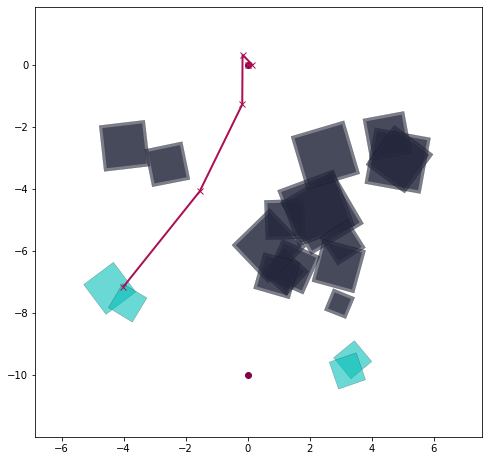

In [6]:

MODE = "EMC"
EXEC = "07"

MAPS_PATH = "./maps/NonRegular/"
EXPERIMENTS_PATH = "./experiments/"
BONUS_PATH = './maps/b_n/bonus_regions.txt'

wp_ori = CartesianPoint(0, 0)
wp_des = CartesianPoint(0, -10)

par_RC = {
            'taxa_cross': 5,
            'population_size': 25,  # !
            'max_exec_time': 180,
            'C_d': 0,
            'C_obs': 10000,
            'C_con': 10,
            'C_cur': 10,
            'C_t': 10,
            'C_dist': 1,
            'C_z_bonus': -10000,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
            'planning_mode': 'emergency',
        }

labels = read_bonus(BONUS_PATH)

# =============================================================================
# use essa célula para visualizar um mapa (sem a rota)

# mapa_name = "10"

# mapa_teste = read_sgl(MAPS_PATH + mapa_name + ".sgl", inflation_rate=0.1, mode="vector")
# vis_mapa(mapa_teste)

# =============================================================================
# aqui executa o AG para um mapa apenas

mapa_name = "27"
ag = run_ags_over_path(MAPS_PATH + mapa_name + ".sgl", show=False)

# =============================================================================
# # # Run all maps and paralellize the execution
# pathlist = PPath(MAPS_PATH).glob("**/*.sgl")

# # Iterate over different maps in parallel
# p = Pool(processes=50)
# p.map(run_ags_over_path, pathlist)

# =============================================================================

# # # Run all maps and paralellize the execution and run with different params

#     for mode in ['EMA', 'EMB', 'EMC', 'EMD']:
#         print('-' * 20, 'Starting execution of mode: ', mode)
#         MODE = mode
#         par_RC = get_parameter(mode)

#         pathlist = PPath(MAPS_PATH).glob("**/*.sgl")

#         # Iterate over different maps in parallel
#         p = Pool(processes=50)
#         p.map(run_ags_over_path, pathlist)
#         print('-' * 20, 'Finished mode: ', mode)


    # =============================================================================

1. Processing file: 07
1.1. Read
2. AG generated: 07
2. Saved: 07


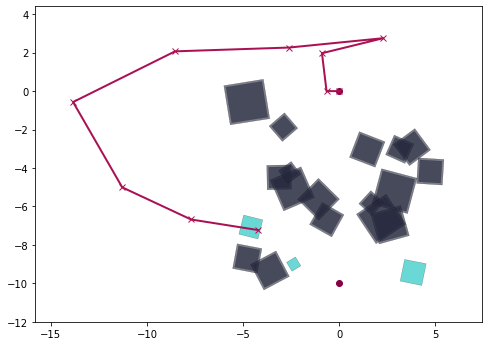

In [9]:

MODE = "EMC"
EXEC = "07"

MAPS_PATH = "./maps/NonRegular/"
EXPERIMENTS_PATH = "./experiments/"
BONUS_PATH = './maps/b_n/bonus_regions.txt'

wp_ori = CartesianPoint(0, 0)
wp_des = CartesianPoint(0, -10)

par_RC = {
            'taxa_cross': 5,
            'population_size': 25,  # !
            'max_exec_time': 60,
            'C_d': 0,
            'C_obs': 10000,
            'C_con': 10,
            'C_cur': 10,
            'C_t': 10,
            'C_dist': 1,
            'C_z_bonus': -10000,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
            'planning_mode': 'emergency',
        }

labels = read_bonus(BONUS_PATH)

# =============================================================================
# use essa célula para visualizar um mapa (sem a rota)

# mapa_name = "10"

# mapa_teste = read_sgl(MAPS_PATH + mapa_name + ".sgl", inflation_rate=0.1, mode="vector")
# vis_mapa(mapa_teste)

# =============================================================================
# aqui executa o AG para um mapa apenas

mapa_name = "07"
ag = run_ags_over_path(MAPS_PATH + mapa_name + ".sgl", show=False)

# =============================================================================
# # # Run all maps and paralellize the execution
# pathlist = PPath(MAPS_PATH).glob("**/*.sgl")

# # Iterate over different maps in parallel
# p = Pool(processes=50)
# p.map(run_ags_over_path, pathlist)

# =============================================================================

# # # Run all maps and paralellize the execution and run with different params

#     for mode in ['EMA', 'EMB', 'EMC', 'EMD']:
#         print('-' * 20, 'Starting execution of mode: ', mode)
#         MODE = mode
#         par_RC = get_parameter(mode)

#         pathlist = PPath(MAPS_PATH).glob("**/*.sgl")

#         # Iterate over different maps in parallel
#         p = Pool(processes=50)
#         p.map(run_ags_over_path, pathlist)
#         print('-' * 20, 'Finished mode: ', mode)


    # =============================================================================

1. Processing file: 07
1.1. Read
2. AG generated: 07
2. Saved: 07


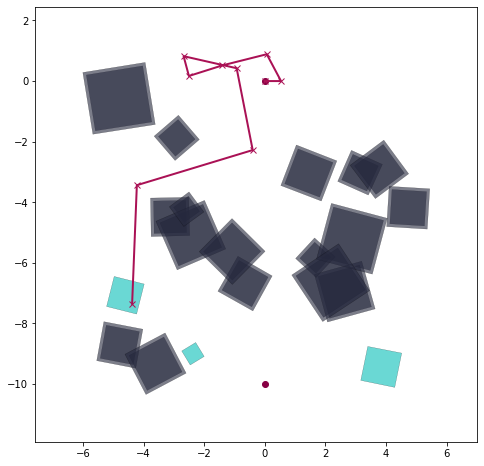

In [10]:

MODE = "EMC"
EXEC = "07"

MAPS_PATH = "./maps/NonRegular/"
EXPERIMENTS_PATH = "./experiments/"
BONUS_PATH = './maps/b_n/bonus_regions.txt'

wp_ori = CartesianPoint(0, 0)
wp_des = CartesianPoint(0, -10)

par_RC = {
            'taxa_cross': 5,
            'population_size': 25,  # !
            'max_exec_time': 180,
            'C_d': 0,
            'C_obs': 10000,
            'C_con': 10,
            'C_cur': 10,
            'C_t': 10,
            'C_dist': 1,
            'C_z_bonus': -10000,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
            'planning_mode': 'emergency',
        }

labels = read_bonus(BONUS_PATH)

# =============================================================================
# use essa célula para visualizar um mapa (sem a rota)

# mapa_name = "10"

# mapa_teste = read_sgl(MAPS_PATH + mapa_name + ".sgl", inflation_rate=0.1, mode="vector")
# vis_mapa(mapa_teste)

# =============================================================================
# aqui executa o AG para um mapa apenas

mapa_name = "07"
ag = run_ags_over_path(MAPS_PATH + mapa_name + ".sgl", show=False)

# =============================================================================
# # # Run all maps and paralellize the execution
# pathlist = PPath(MAPS_PATH).glob("**/*.sgl")

# # Iterate over different maps in parallel
# p = Pool(processes=50)
# p.map(run_ags_over_path, pathlist)

# =============================================================================

# # # Run all maps and paralellize the execution and run with different params

#     for mode in ['EMA', 'EMB', 'EMC', 'EMD']:
#         print('-' * 20, 'Starting execution of mode: ', mode)
#         MODE = mode
#         par_RC = get_parameter(mode)

#         pathlist = PPath(MAPS_PATH).glob("**/*.sgl")

#         # Iterate over different maps in parallel
#         p = Pool(processes=50)
#         p.map(run_ags_over_path, pathlist)
#         print('-' * 20, 'Finished mode: ', mode)


    # =============================================================================

1. Processing file: 07
1.1. Read
2. AG generated: 07
2. Saved: 07


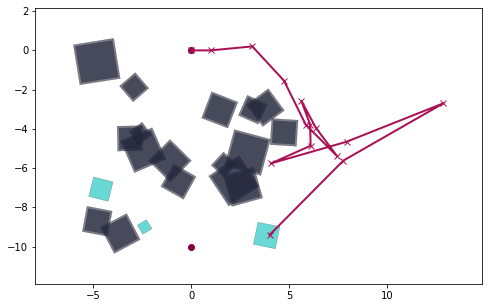

In [12]:

MODE = "EMC"
EXEC = "07"

MAPS_PATH = "./maps/NonRegular/"
EXPERIMENTS_PATH = "./experiments/"
BONUS_PATH = './maps/b_n/bonus_regions.txt'

wp_ori = CartesianPoint(0, 0)
wp_des = CartesianPoint(0, -10)

par_RC = {
            'taxa_cross': 5,
            'population_size': 25,  # !
            'max_exec_time': 60,
            'C_d': 0,
            'C_obs': 10000,
            'C_con': 0, # !
            'C_cur': 0, # !
            'C_t': 0, # !
            'C_dist': 0, # !
            'C_z_bonus': -10000,
            'v_min': -3.0,
            'v_max': 3.0,
            'e_min': -3,
            'e_max': 3,
            'a_min': -2.0,
            'a_max': 2.0,
            'T_min': 1,
            'T_max': 25,
            'mutation_prob': 0.7,
            'gps_imprecision': 1,
            'planning_mode': 'emergency',
        }

labels = read_bonus(BONUS_PATH)

# =============================================================================
# use essa célula para visualizar um mapa (sem a rota)

# mapa_name = "10"

# mapa_teste = read_sgl(MAPS_PATH + mapa_name + ".sgl", inflation_rate=0.1, mode="vector")
# vis_mapa(mapa_teste)

# =============================================================================
# aqui executa o AG para um mapa apenas

mapa_name = "07"
ag = run_ags_over_path(MAPS_PATH + mapa_name + ".sgl", show=False)

# =============================================================================
# # # Run all maps and paralellize the execution
# pathlist = PPath(MAPS_PATH).glob("**/*.sgl")

# # Iterate over different maps in parallel
# p = Pool(processes=50)
# p.map(run_ags_over_path, pathlist)

# =============================================================================

# # # Run all maps and paralellize the execution and run with different params

#     for mode in ['EMA', 'EMB', 'EMC', 'EMD']:
#         print('-' * 20, 'Starting execution of mode: ', mode)
#         MODE = mode
#         par_RC = get_parameter(mode)

#         pathlist = PPath(MAPS_PATH).glob("**/*.sgl")

#         # Iterate over different maps in parallel
#         p = Pool(processes=50)
#         p.map(run_ags_over_path, pathlist)
#         print('-' * 20, 'Finished mode: ', mode)


    # =============================================================================